# Images
The image files for leaves can be downloaded from the Dryad repository https://doi.org/10.5061/dryad.3ffbg79m8. After downloading and unzipping the file, the following directory path should be used to access the leaves: `./doi_10_5061_dryad_3ffbg79m8__v20220523/all_leaves/20190614/`. It is associated with the following publication:  https://doi.org/10.1002/ajb2.16033.

# Blade outline data
The outline data is located in the zipped folder `outlines_20190614`.

# Landmark and metadata
The metadata for the leaves can be downloaded from the file `goali_all_data.csv` in the github repo https://github.com/zoemigicovsky/grape_leaf_temp using the following url: https://raw.githubusercontent.com/zoemigicovsky/grape_leaf_temp/main/data/goali_all_data.csv. It is associated with the following publication: https://doi.org/10.20870/oeno-one.2024.58.2.7735

# Folder structure
The following folder structure is necessary to run this code:

* Images: `./doi_10_5061_dryad_3ffbg79m8__v20220523/all_leaves/20190614/`
* Outlines: `./outlines_20190614/`
* Empty folder to store image check plots: `./check_plots_20180614/`
* Empty folder to store leaf check plots: `./check_leaves_20190614/`
* Empty folder to store leaf images: `./check_images_20190614/`

In [1]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn
from PIL import Image # for opening images
Image.MAX_IMAGE_PIXELS = None # to stop warnings for reading in large images
import matplotlib.gridspec as gridspec # for subplot spacing of images

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

def rotate_image(img, angle):
    """
    define a function that rotates an image by a given angle
    from https://stackoverflow.com/questions/43892506/opencv-python-rotate-image-without-cropping-sides
    inputs: image and angle
    output: rotated image
    
    """
    size_reverse = np.array(img.shape[1::-1]) # swap x with y
    M = cv2.getRotationMatrix2D(tuple(size_reverse / 2.), angle, 1.)
    MM = np.absolute(M[:,:2])
    size_new = MM @ size_reverse
    M[:,-1] += (size_new - size_reverse) / 2.
    return cv2.warpAffine(img, M, tuple(size_new.astype(int)))


# Find matches between outlines and landmarks

In [3]:
############################################
### FIND MATCHES FOR GOALI 20190614 DATA ###
############################################

###
### create lists of unique outline and image file names
###

outline_dir = "./outlines_20190614/" # set data directory

outline_names = [f for f in listdir(outline_dir) if isfile(join(outline_dir, f))] # create a list of outline names

outline_names.remove('.DS_Store') # remove .DS_Store file

outline_names.sort() # sort the list of outlines names

### remove the prefix and suffix to get just the image file IDs

img_names = [] # a list to store just image file names

for outline in outline_names: # for each outline
    
    img_names.append(outline[3:-5]) # store just the image file name
    
img_names = list(set(img_names)) # retrieve just unique image file names

img_names.sort() # sort the list of image file names

###
### read in landmark data
###

url = "https://raw.githubusercontent.com/zoemigicovsky/grape_leaf_temp/main/data/goali_all_data.csv"
landmark_data = pd.read_csv(url) # read data in from csv

landmark_2019 = landmark_data[landmark_data["year"]==2019] # mask just 2019 data

###
### find matches between outlines and data
###

matches_images = [] # list of lists of image matches
matches_outlines = [] # list of lists for outline file matches
matches_indices = [] # list of lists for data index matches

limit = 200 # set a limit for distance of range of match

for i in range(len(img_names)): # for each image file

    curr_img = img_names[i] # get the current image file
    
    print(i, curr_img) # print current image being considered
    
    if "_" in curr_img: # if there are underscores in the image name, then skip
        continue
        
    curr_data = landmark_2019[landmark_2019["accession"]==int(curr_img)] # get just the data for the current image
    
    outlines = [] # store outline file names with matches
    leaf_indices = [] # store index of landmark data for the match

    for outline in outline_names: # for each outline name

        if curr_img in outline: # if the current image file name is in the outline file name

            outline_data = np.loadtxt(outline_dir + outline) # retrieve the outline data

            tip_min_vals = [] # a list to store minimum values of each leaf tip in the image to the current outline
            base_min_vals = [] # a list to store minimum values of each leaf base in the image to the current outline

            for leaf in range(len(curr_data)): # for each leaf in the current data

                # retrieve base and tip coordinates for current leaf
                base_x = curr_data["x1"].iloc[leaf]
                base_y = curr_data["y1"].iloc[leaf]
                tip_x = curr_data["x21"].iloc[leaf]
                tip_y = curr_data["y21"].iloc[leaf]
                
                # for images with these resolutions, we need to switch axes and flip one
                if curr_data["px2_cm2"].iloc[0]==227529:
                    
                    # retrieve base and tip coordinates for current leaf
                    base_x = -curr_data["y1"].iloc[leaf]+10208
                    base_y = curr_data["x1"].iloc[leaf]
                    tip_x = -curr_data["y21"].iloc[leaf]+10208
                    tip_y = curr_data["x21"].iloc[leaf]
                    
                tip_dists = [] # store distances to the tip for each coord of current outline
                base_dists = [] # store distances to the base for each coord of current outline

                for coord in range(len(outline_data)): # for each coord in the outline we're trying to match

                    # calculate and store distances of each coord to the leaf tip
                    tip_dists.append(euclid_dist( 
                        outline_data[coord,0],
                        outline_data[coord,1],
                        tip_x,
                        tip_y))

                    # calculate and store distances of each coord to the leaf base
                    base_dists.append(euclid_dist(
                        outline_data[coord,0],
                        outline_data[coord,1],
                        base_x,
                        base_y))

                # for the current outline for the current leaf, calculate minimum distances to tip and base
                tip_min_vals.append(min(tip_dists))
                base_min_vals.append(min(base_dists))

            # if the minimum tip and base distances are < limit, and they have same index, then a match
            if (min(tip_min_vals)<limit) & (min(base_min_vals)<limit) & (tip_min_vals.index(min(tip_min_vals))==base_min_vals.index(min(base_min_vals))):

                # append matched outline and index
                outlines.append(outline)
                leaf_indices.append(curr_data.index[tip_min_vals.index(min(tip_min_vals))])
        
        # if no match for the current image in outline file names, then continue
        else:
            continue
            
    matches_images.append(curr_img) # store the associate image with the matched outlines and indices
    matches_outlines.append(outlines) # store matched outlines to overall list
    matches_indices.append(leaf_indices) # store matched data indices to overall list
             

0 16113001_1
1 16113001_2
2 16113001_3
3 16113002
4 16113003
5 16113004
6 16113005
7 16113006
8 16113007
9 16113008
10 16113009
11 16113010
12 16113011
13 16113012
14 16113013
15 16113014
16 16113015
17 16113017
18 16113018
19 16113019
20 16113020
21 16113021
22 16113022
23 16113023
24 16113024
25 16113025
26 16113026
27 16113027
28 16113028
29 16113029
30 16113030
31 16113031
32 16113032
33 16113033
34 16113034
35 16113035
36 16113036
37 16113037
38 16113038
39 16113039
40 16113040
41 16113041
42 16113042
43 16113043
44 16113044
45 16113045
46 16113046
47 16113047
48 16113048
49 16113049
50 16113050


# Check matches on original images

In [4]:
#####################
### CHECK MATCHES ###
#####################

# where to get images
image_dir = "./doi_10_5061_dryad_3ffbg79m8__v20220523/all_leaves/20190614/"

# where to save plots
plot_dir = "./check_plots_20190614/"

# calculate indices for plotting vasculature
vein_landmarks = np.array([1,6,14,5,15,7,2,9,17,8,18,10,3,12,20,11,21,13,4])
vein_x_indices = vein_landmarks*2 
vein_y_indices = vein_x_indices + 1

# calculate indices for plotting blade
blade_landmarks = np.array([1,6,14,15,16,17,18,19,20,21])
blade_x_indices = blade_landmarks*2 
blade_y_indices = blade_x_indices + 1

cols = ["magenta", "orange", "dodgerblue"] # colors to cycle through
a = 0.2 # set alpha of filled image

for i in range(len(matches_images)): # for each image

    img = matches_images[i] # select the image name
    
    print(i, img) # print image name

    img = Image.open(image_dir + img + ".jpg") # open image

    plt.imshow(img) # plot image

    for lf in range(len(matches_outlines[i])): # for each leaf in the image

        out = matches_outlines[i][lf] # select the outline

        outline_data = np.loadtxt(outline_dir + out) # retrieve the outline data

        land = matches_indices[i][lf] # select the index of the landmarks
        subset = landmark_data.iloc[land] # select the landmark data using the index

        # for images with these resolutions, we need to switch axes and flip one
        if subset["px2_cm2"]==227529:

            plt.fill(outline_data[:,0], outline_data[:,1], c=cols[lf], alpha=a) # plot outline: NO CHANGE
            plt.fill(-subset[vein_y_indices]+10208, subset[vein_x_indices], c=cols[lf]) # plot vein landmarks: CHANGE THESE
            plt.plot(-subset[blade_y_indices]+10208, subset[blade_x_indices], c=cols[lf]) # plot blade landmarks: CHANGE THESE
            plt.axis("off")
            
        else:
            plt.fill(outline_data[:,0], outline_data[:,1], c=cols[lf], alpha=a) # plot outline
            plt.fill(subset[vein_x_indices], subset[vein_y_indices], c=cols[lf]) # plot vein landmarks
            plt.plot(subset[blade_x_indices], subset[blade_y_indices], c=cols[lf]) # plot blade landmarks
            plt.axis("off")

    plt.savefig(plot_dir + "goali_20190614_" + matches_images[i] + ".jpg", dpi=300, bbox_inches='tight')
    plt.close()

0 16113002
1 16113003
2 16113004
3 16113005
4 16113006
5 16113007
6 16113008
7 16113009
8 16113010
9 16113011
10 16113012
11 16113013
12 16113014
13 16113015
14 16113017
15 16113018
16 16113019
17 16113020
18 16113021
19 16113022
20 16113023
21 16113024
22 16113025
23 16113026
24 16113027
25 16113028
26 16113029
27 16113030
28 16113031
29 16113032
30 16113033
31 16113034
32 16113035
33 16113036
34 16113037
35 16113038
36 16113039
37 16113040
38 16113041
39 16113042
40 16113043
41 16113044
42 16113045
43 16113046
44 16113047
45 16113048
46 16113049
47 16113050


# Interpolate, rotate, and scale points

In [5]:
#############################################
### INTERPOLATE, ROTATE, AND SCALE POINTS ###
#############################################

# redefine landmarks here
vein_landmarks = np.array([1,6,14,5,15,7,2,9,17,8,18,10,3,12,20,11,21,13,4])
blade_landmarks = np.array([1,6,14,15,16,17,18,19,20,21])

# set resolution
# the ultimate number of equidistant points on each side of the leaf
# landmarked side is divided into 8 segments, so res should be a multiple of 8
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks

res = 8*15 # 120

# calculate the final length of the interpolated leaf
# 21 landmarks +
# res-1, the number of landmarks on the pseudolandmark side of the leaf +
# (res//8)*8 - 8, the res divided by 8 across 8 segments of landmark side - 8 removed points
final_len = 21 + (res-1) + (res//8)*8 - 8 

# calculate the final tip index of the interpolated leaf
final_tip_ind = (res//8)*8 - 8

# define function to get number of leaves in an arbitrary list of lists
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1
    
# get number of leaves
leaf_num = recursive_len(matches_outlines)

# where to save plots to check leaves
leaf_plot_dir = "./check_leaves_20190614/"

# create an array to store cm-scaled leaves
cm_arr = np.zeros((leaf_num,final_len,2))

# create a lists to store population, accession, and year
pop_list = []
acc_list = []
year_list = []

# counter to store leaves in cm_arr
counter = 0

for i in range(len(matches_images)): # for each image
    for j in range(len(matches_outlines[i])): # for each leaf in the current image

        ###
        ### GET OUTLINE AND LANDMARK DATA
        ###

        outline = matches_outlines[i][j] # get the matched leaf outline name
        print(outline)
        outline_data = np.loadtxt(outline_dir + outline) # retrieve the outline data

        land = matches_indices[i][j] # select the index of the landmarks
        subset = landmark_data.iloc[land] # select the landmark data using the index
        landmarks = np.array(subset[2:44:]) # isolate just the landmarks as array, x1,y1,x2,y2...x21,y21

        scale = subset["px2_cm2"] # isolate px2_cm2
        pop_list.append(subset["pop"]) # get population and append to list
        acc_list.append(subset["accession"]) # get accession and append to list
        year_list.append(subset["year"]) # get year and append to list

        # alter landmarks based on scale
        if scale==227529:
            yvals = landmarks[0:42:2] # switch x vals to y vals
            xvals = -landmarks[1:42:2]+10208 # switch -y vals + 10208 to x vals
            landmarks = np.array(list(map(list, zip(xvals, yvals)))) # create new landmark array

        else:
            landmarks = np.reshape(landmarks, (21,2)) # for other scale, make array the same shape
            
        ###
        ### FIND BASE AND TIP POINT INDICES AND REINDEX SIDES OF LEAF WITH AND WITHOUT LANDMARKS
        ###
        
        base_pt = landmarks[0] # isolate the base point
        tip_pt = landmarks[20] # isolate the tip point
        base_dists = [] # to store distances of each outline point to base landmark
        tip_dists = [] # to store distances of each outline point to tip landmark
        for pt in range(len(outline_data)): # for each of the outline points
            # calculate distance of each to the base
            base_dists.append(
                euclid_dist(
                    base_pt[0], base_pt[1], 
                    outline_data[pt,0], outline_data[pt,1] ))
                   # calculate distance of each to the base
            tip_dists.append(
                euclid_dist(
                    tip_pt[0], tip_pt[1], 
                    outline_data[pt,0], outline_data[pt,1] ))
            
        # get index of the corresponding point on the outline to the base
        base_ind = np.argmin(base_dists)
        
        # get index of the corresponding point on the outline to the tip
        tip_ind = np.argmin(tip_dists)
        
        # reset base index position to zero
        reset_data = np.concatenate((outline_data[base_ind:],outline_data[:base_ind]))
        
        # reset base and tip indices
        reset_base_ind = 0
        reset_tip_ind = tip_ind-base_ind
        
        # divide leaf into two sides
        left_side = reset_data[reset_base_ind:reset_tip_ind+1,:]
        right_side = reset_data[-1:reset_tip_ind-1:-1,:]
        right_side = np.insert(right_side, 0, reset_data[reset_base_ind], axis=0)
        
        # calculate the centroid of landmarks, and left and right sides of leaf
        landmark_mean = np.mean(landmarks, axis=0)
        right_mean = np.mean(right_side, axis=0)
        left_mean = np.mean(left_side, axis=0)
        
        # calculate euclidean distances between landmark centroid with left and right side centroids
        right_dist = euclid_dist(landmark_mean[0],landmark_mean[1],right_mean[0],right_mean[1])
        left_dist = euclid_dist(landmark_mean[0],landmark_mean[1],left_mean[0],left_mean[1])
        
        # set the landmark and pseudo-landmark sides of the leaf based on the distances
        if right_dist<left_dist:
            land_side = right_side
            pseudo_side = left_side
        else:
            land_side = left_side
            pseudo_side = right_side
            
        ###
        ### REINDEX OUTLINE BASED ON LANDMARKS on LANDMARK SIDE
        ###
            
        # get the landmark point values of interest
        prox_branch_pt = landmarks[13]
        prox_tip_pt = landmarks[14]
        prox_sinus_pt = landmarks[15]
        dist_branch_pt = landmarks[16]
        dist_tip_pt = landmarks[17]
        dist_sinus_pt = landmarks[18]
        midvein_branch_pt = landmarks[19]

        # store distance of each landmark side point to landmark
        prox_branch_dists = []
        prox_tip_dists = []
        prox_sinus_dists = []
        dist_branch_dists = []
        dist_tip_dists = []
        dist_sinus_dists = []
        midvein_branch_dists = []

        for pt in range(len(land_side)): # for each of the landmark side points

            # calculate distance of each 
            
            prox_branch_dists.append(
                euclid_dist(
                    prox_branch_pt[0], prox_branch_pt[1], 
                    land_side[pt,0], land_side[pt,1] ))
            
            prox_tip_dists.append(
                euclid_dist(
                    prox_tip_pt[0], prox_tip_pt[1], 
                    land_side[pt,0], land_side[pt,1] ))
            
            prox_sinus_dists.append(
                euclid_dist(
                    prox_sinus_pt[0], prox_sinus_pt[1], 
                    land_side[pt,0], land_side[pt,1] ))
            
            dist_branch_dists.append(
                euclid_dist(
                    dist_branch_pt[0], dist_branch_pt[1], 
                    land_side[pt,0], land_side[pt,1] ))
            
            dist_tip_dists.append(
                euclid_dist(
                    dist_tip_pt[0], dist_tip_pt[1], 
                    land_side[pt,0], land_side[pt,1] ))
            
            dist_sinus_dists.append(
                euclid_dist(
                    dist_sinus_pt[0], dist_sinus_pt[1], 
                    land_side[pt,0], land_side[pt,1] ))
            
            midvein_branch_dists.append(
                euclid_dist(
                    midvein_branch_pt[0], midvein_branch_pt[1], 
                    land_side[pt,0], land_side[pt,1] ))
    
        # get indices of the corresponding points on the landmark side to the landmarks
        prox_branch_ind = np.argmin(prox_branch_dists)
        prox_tip_ind = np.argmin(prox_tip_dists)
        prox_sinus_ind = np.argmin(prox_sinus_dists)
        dist_branch_ind = np.argmin(dist_branch_dists)
        dist_tip_ind = np.argmin(dist_tip_dists)
        dist_sinus_ind = np.argmin(dist_sinus_dists)
        midvein_branch_ind = np.argmin(midvein_branch_dists)
        
        ###
        ### INTERPOLATE LANDMARK SIDE WITH DESIRED NUMBER OF LANDMARKS ACROSS SEGMENTS
        ###
        
        # divide the landmarked margin into 8 segments (0-7), from base to tip
        seg0_x, seg0_y = interpolation(
            land_side[0:prox_branch_ind+1,0],
            land_side[0:prox_branch_ind+1,1], res//8)
        seg1_x, seg1_y = interpolation(
            land_side[prox_branch_ind:prox_tip_ind+1,0],
            land_side[prox_branch_ind:prox_tip_ind+1,1], res//8)
        seg2_x, seg2_y = interpolation(
            land_side[prox_tip_ind:prox_sinus_ind+1,0],
            land_side[prox_tip_ind:prox_sinus_ind+1,1], res//8)
        seg3_x, seg3_y = interpolation(
            land_side[prox_sinus_ind:dist_branch_ind+1,0],
            land_side[prox_sinus_ind:dist_branch_ind+1,1], res//8)
        seg4_x, seg4_y = interpolation(
            land_side[dist_branch_ind:dist_tip_ind+1,0],
            land_side[dist_branch_ind:dist_tip_ind+1,1], res//8)
        seg5_x, seg5_y = interpolation(
            land_side[dist_tip_ind:dist_sinus_ind+1,0],
            land_side[dist_tip_ind:dist_sinus_ind+1,1], res//8)
        seg6_x, seg6_y = interpolation(
            land_side[dist_sinus_ind:midvein_branch_ind+1,0],
            land_side[dist_sinus_ind:midvein_branch_ind+1,1], res//8)
        seg7_x, seg7_y = interpolation(
            land_side[midvein_branch_ind:,0],
            land_side[midvein_branch_ind:,1], res//8)
        
        # divide up the pseudo side by the resolution
        seg8_x, seg8_y = interpolation(
            pseudo_side[0:,0],
            pseudo_side[0:,1], res)
        
        # delete the last point of each segment up to the tip
        # elimninates redundant points while maintaining spacing
        
        seg0_x = np.delete(seg0_x, -1)
        seg0_y = np.delete(seg0_y, -1)
        
        seg1_x = np.delete(seg1_x, -1)
        seg1_y = np.delete(seg1_y, -1)
        
        seg2_x = np.delete(seg2_x, -1)
        seg2_y = np.delete(seg2_y, -1)
        
        seg3_x = np.delete(seg3_x, -1)
        seg3_y = np.delete(seg3_y, -1)
        
        seg4_x = np.delete(seg4_x, -1)
        seg4_y = np.delete(seg4_y, -1)
        
        seg5_x = np.delete(seg5_x, -1)
        seg5_y = np.delete(seg5_y, -1)
        
        seg6_x = np.delete(seg6_x, -1)
        seg6_y = np.delete(seg6_y, -1)
        
        seg7_x = np.delete(seg7_x, -1)
        seg7_y = np.delete(seg7_y, -1)
        
        # delete the first point on the pseudo side, the base, covered by the landmark side already
        seg8_x = np.delete(seg8_x, 0)
        seg8_y = np.delete(seg8_y, 0)
        
        # flip the pseudo side so continuous with the landmark side
        seg8_x = np.flip(seg8_x)
        seg8_y = np.flip(seg8_y)
        
        # stack the segment points
        seg0_pts = np.column_stack((seg0_x, seg0_y))
        seg1_pts = np.column_stack((seg1_x, seg1_y))
        seg2_pts = np.column_stack((seg2_x, seg2_y))
        seg3_pts = np.column_stack((seg3_x, seg3_y))
        seg4_pts = np.column_stack((seg4_x, seg4_y))
        seg5_pts = np.column_stack((seg5_x, seg5_y))
        seg6_pts = np.column_stack((seg6_x, seg6_y))
        seg7_pts = np.column_stack((seg7_x, seg7_y))
        seg8_pts = np.column_stack((seg8_x, seg8_y))
        
        # combine coordinates into a single, 2D array
        lf_pts = np.row_stack((seg0_pts, seg1_pts, seg2_pts, seg3_pts, seg4_pts, seg5_pts, seg6_pts, seg7_pts, seg8_pts))

        ###
        ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS
        ###

        tip_point = lf_pts[final_tip_ind,:] # get tip point
        base_point = lf_pts[0,:] # get base point

        # calculate angle between tip, base, and an arbitrary reference
        ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

        # rotate outline points downwards
        rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang+180) 
        rot_outline_pts = np.column_stack((rot_x, rot_y))

        # rotate landmark points downwards
        rot_x, rot_y = rotate_points(landmarks[:,0], landmarks[:,1], ang+180) 
        rot_landmark_pts = np.column_stack((rot_x, rot_y))

        # combine landmark and outline points
        # landmark points are 0:21
        # outline points are 21:end

        all_rot_pts = np.row_stack((rot_landmark_pts, rot_outline_pts))

        # scale points into cm
        cm_lf = all_rot_pts/np.sqrt(scale)

        # store the leaf scaled into cm into the cm_arr
        cm_arr[counter,:,:] = cm_lf
        
        # increase counter by 1
        counter+=1
        
        # check leaf by plot
        plt.plot(cm_lf[vein_landmarks-1,0], cm_lf[vein_landmarks-1,1]) # plot vein landmarks
        plt.plot(cm_lf[blade_landmarks-1,0], cm_lf[blade_landmarks-1,1]) # plot blade landmarks
        plt.plot(cm_lf[21:,0], cm_lf[21:,1]) # plot blade outline
        plt.scatter(cm_lf[21+final_tip_ind,0], cm_lf[21+final_tip_ind,1]) # plot tip index
        plt.plot( [np.min(cm_lf[:,0]),np.min(cm_lf[:,0])+1], # plot 1 cm scale bar
                  [np.min(cm_lf[:,1]),np.min(cm_lf[:,1])], c="k")

        plt.axis("off")
        plt.gca().set_aspect("equal")
        plt.tight_layout()
        plt.savefig(leaf_plot_dir+"goal_20190614_"+outline[:-4]+".jpg", bbox_inches='tight', dpi=300)
        plt.close()


out16113002a.txt
out16113002b.txt
out16113002c.txt
out16113003a.txt
out16113003b.txt
out16113003c.txt
out16113004a.txt
out16113004b.txt
out16113004c.txt
out16113005a.txt
out16113005b.txt
out16113005c.txt
out16113006a.txt
out16113006b.txt
out16113006c.txt
out16113007a.txt
out16113007b.txt
out16113007c.txt
out16113008a.txt
out16113008b.txt
out16113008c.txt
out16113009a.txt
out16113009b.txt
out16113010a.txt
out16113010b.txt
out16113010c.txt
out16113011.ctxt
out16113011a.txt
out16113011b.txt
out16113012a.txt
out16113012b.txt
out16113012c.txt
out16113013a.txt
out16113013b.txt
out16113013c.txt
out16113014a.txt
out16113014b.txt
out16113014c.txt
out16113015a.txt
out16113015b.txt
out16113015c.txt
out16113017a.txt
out16113017b.txt
out16113017c.txt
out16113018a.txt
out16113018b.txt
out16113018c.txt
out16113019a.txt
out16113019b.txt
out16113019c.txt
out16113020a.txt
out16113020b.txt
out16113020c.txt
out16113021a.txt
out16113021b.txt
out16113021c.txt
out16113022a.txt
out16113022b.txt
out16113022c.t

# Analyze dimensions

/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


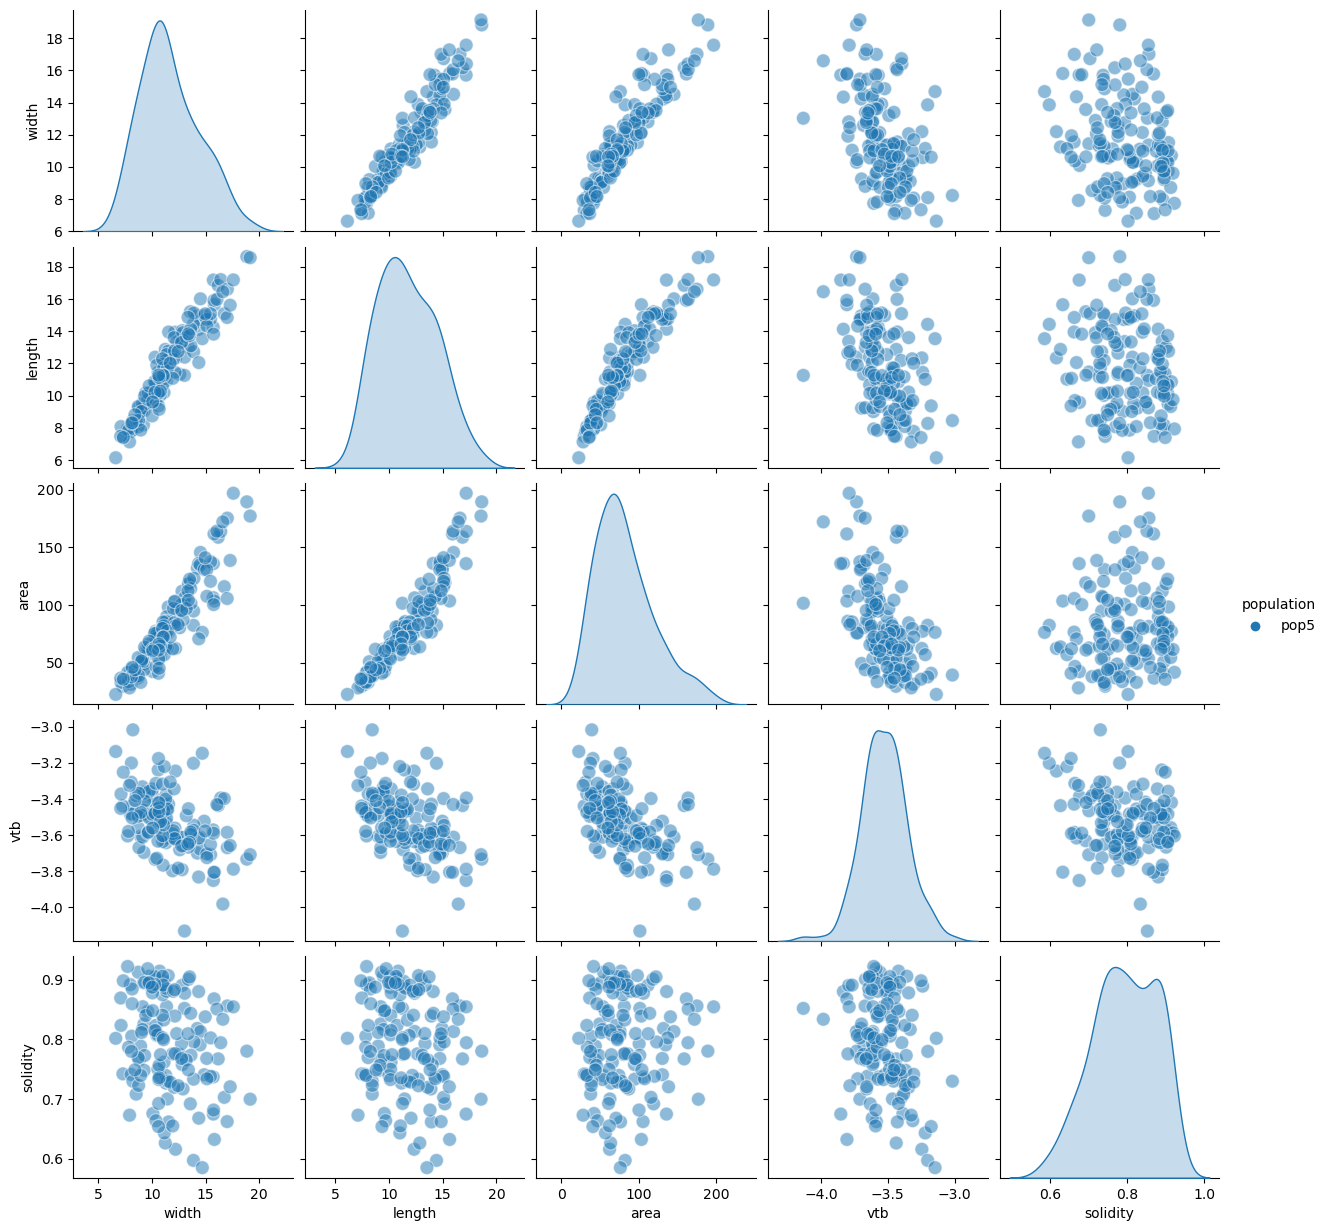

In [6]:
##########################
### MEASURE DIMENSIONS ###
##########################

# lists to store variables
width_list = []
length_list = []
area_list = []
vtb_list = []
solidity_list = []

# for each leaf . . .
for lf in range(len(cm_arr)):
    
    # for calculating dimensions, we need non-scaled leaves in centimeters
    curr_lf = cm_arr[lf,21:,:] # select current leaf outline
    
    ###
    ### CALCULATE DIMENSIONS 
    ###
    
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    area = poly_area(curr_lf[:,0],curr_lf[:,1]) # calculate area
    
    ###
    ### CALCULATE VEIN-TO-BLADE RATIO
    ###
    
    veins = cm_arr[lf,vein_landmarks-1,:] # isolate just the vein landmarks
    vein_area = poly_area(veins[:,0], veins[:,1]) # calculate vein area
    blade_area = area - vein_area # calculate blade area
    vtb = np.log(vein_area/blade_area) # calcualte vein-to-blade ratio
    
    ###
    ### CALCULATE SOLIDITY 
    ###
    
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity = area / convex_area # calculate solidity
    
    # store data in lists
    width_list.append(width)
    length_list.append(length)
    area_list.append(area)
    vtb_list.append(vtb)
    solidity_list.append(solidity)
    
# create dataframe of dimension data

dim_df = pd.DataFrame({"accession":acc_list,
      "population":pop_list,
      "year":year_list,
      "width":width_list,
      "length":length_list,
      "area":area_list,
      "vtb":vtb_list,
      "solidity":solidity_list
})

# plot out dimension data

sns.pairplot(dim_df,
             x_vars=["width", "length", "area","vtb","solidity"],
             y_vars=["width", "length", "area","vtb","solidity"],
             hue="population",
             plot_kws={"s": 100, "alpha":0.5, "lw":0}
            )
    


# Procrustes analysis

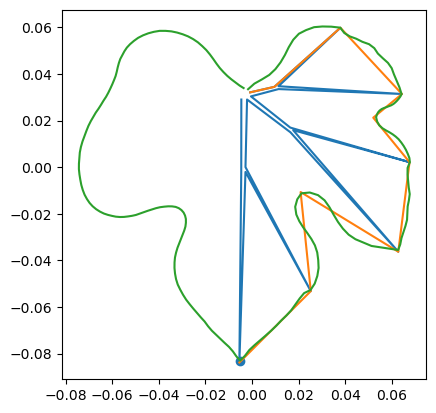

In [7]:
landmark_num = final_len # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

###
### CALCULATE GPA MEAN 
###

mean_shape = gpa_mean(cm_arr, landmark_num, dim_num)

###
### ALIGN LEAVES TO GPA MEAN
###

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(cm_arr)) 

for i in range(len(cm_arr)):
    s1, s2, distance = procrustes(mean_shape, cm_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    
###
### PLOT GPA MEAN
###

plt.plot(mean_shape[vein_landmarks-1,0], mean_shape[vein_landmarks-1,1])
plt.plot(mean_shape[blade_landmarks-1,0], mean_shape[blade_landmarks-1,1])
plt.plot(mean_shape[21:,0], mean_shape[21:,1])

plt.scatter(mean_shape[21+final_tip_ind,0], mean_shape[21+final_tip_ind,1])

plt.gca().set_aspect("equal")
    

# Principal Component Analysis

In [8]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = np.shape(proc_arr)[0] # PC number = number of leaves
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 52.9%, 52.9%
PC2: 13.5%, 66.4%
PC3: 8.9%, 75.3%
PC4: 5.2%, 80.5%
PC5: 4.1%, 84.6%
PC6: 2.3%, 86.8%
PC7: 1.8%, 88.7%
PC8: 1.7%, 90.3%
PC9: 1.2%, 91.6%
PC10: 1.2%, 92.8%
PC11: 0.9%, 93.7%
PC12: 0.7%, 94.4%
PC13: 0.6%, 95.0%
PC14: 0.5%, 95.5%
PC15: 0.5%, 96.0%
PC16: 0.4%, 96.4%
PC17: 0.4%, 96.8%
PC18: 0.3%, 97.1%
PC19: 0.3%, 97.4%
PC20: 0.2%, 97.6%
PC21: 0.2%, 97.8%
PC22: 0.2%, 98.0%
PC23: 0.2%, 98.2%
PC24: 0.2%, 98.3%
PC25: 0.1%, 98.4%
PC26: 0.1%, 98.6%
PC27: 0.1%, 98.7%
PC28: 0.1%, 98.8%
PC29: 0.1%, 98.8%
PC30: 0.1%, 98.9%
PC31: 0.1%, 99.0%
PC32: 0.1%, 99.1%
PC33: 0.1%, 99.1%
PC34: 0.1%, 99.2%
PC35: 0.1%, 99.2%
PC36: 0.0%, 99.3%
PC37: 0.0%, 99.3%
PC38: 0.0%, 99.4%
PC39: 0.0%, 99.4%
PC40: 0.0%, 99.4%
PC41: 0.0%, 99.5%
PC42: 0.0%, 99.5%
PC43: 0.0%, 99.5%
PC44: 0.0%, 99.5%
PC45: 0.0%, 99.6%
PC46: 0.0%, 99.6%
PC47: 0.0%, 99.6%
PC48: 0.0%, 99.6%
PC49: 0.0%, 99.7%
PC50: 0.0%, 99.7%
PC51: 0.0%, 99.7%
PC52: 0.0%, 99.7%
PC53: 0.0%, 99.7%
PC54: 0.0%, 99.7%
PC55: 0.0%, 99.7%

In [9]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # PC number = 2, for limiting to 2 axes for morphospace reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

# add PCs to dataframe for plotting
PC_df = pd.DataFrame({
    "PC1":PCs[:,0],
    "PC2":PCs[:,1] 
})


PC: var, overall 
PC1: 52.9%, 52.9%
PC2: 13.5%, 66.4%


# Morphospace 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Procrustean morphospace')

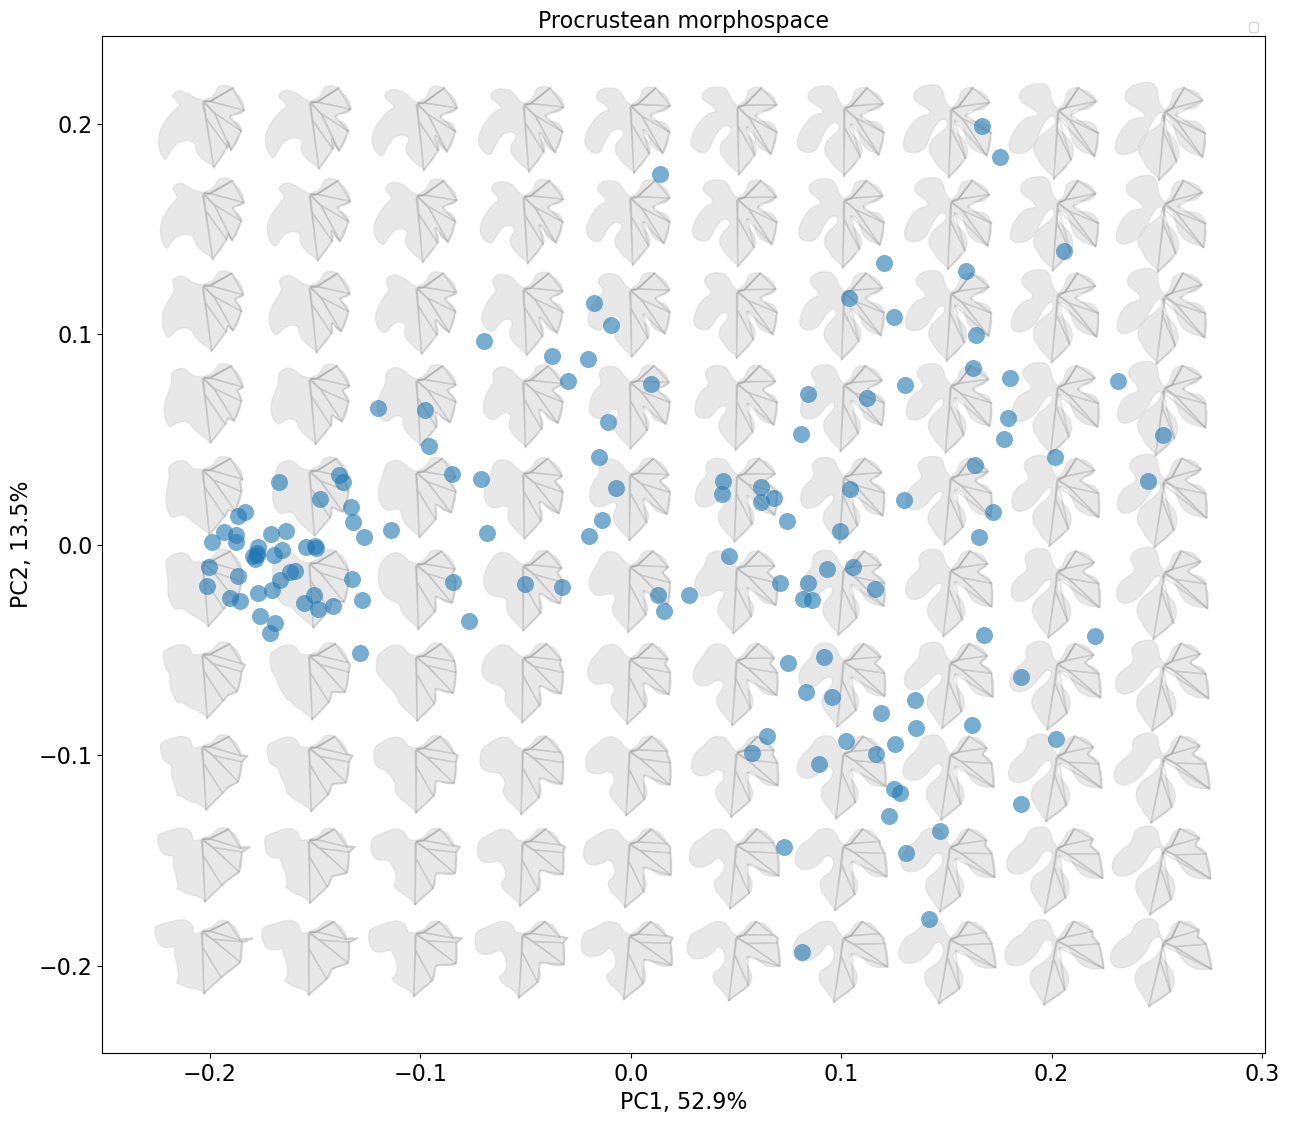

In [10]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 15 # plot length in inches
plot_width= 15 # plot length in inches
numPC1 = 10 # set number of PC1 intervals
numPC2 = 10 # set number of PC2 intervals
#hue = "genotype" # select the factor to color by
s = 0.27 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse blade outline
ld_col = "k" # color of landmark data
ld_alpha = 0.1 # alpha of inverse landmark data
pt_size = 150 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 16 # font size of the x and y axis titles
ax_tick_fs = 16 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.0 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        inv_blade_x = inv_x[21:] # select just blade x vals
        inv_blade_y = inv_y[21:] # select just blade y vals
        inv_vein_x = inv_x[0:21] # select just vein x vals
        inv_vein_y = inv_y[0:21] # select just vein y vals
        
        # plot the inverse blade
        plt.fill(inv_blade_x*s+pc1_val, inv_blade_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
        
        # plot the inverse landmark vasculature
        plt.fill(inv_vein_x[vein_landmarks-1]*s+pc1_val, inv_vein_y[vein_landmarks-1]*s+pc2_val, c=ld_col, alpha=ld_alpha)
        
        # plot the inverse landmark blade
        plt.plot(inv_vein_x[blade_landmarks-1]*s+pc1_val, inv_vein_y[blade_landmarks-1]*s+pc2_val, c=ld_col, alpha=ld_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=PC_df, x="PC1", y="PC2", s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha, zorder=4)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.grid(alpha=grid_alpha)
plt.gca().set_axisbelow(True)
plt.title(title, fontsize=ax_label_fs)


# Analysis of grayscale images

In [11]:
# where to get images
image_dir = "./doi_10_5061_dryad_3ffbg79m8__v20220523/all_leaves/20190614/"

# where to save images
image_save_dir = "./check_images_20190614/"

# set kernel size for contrast
k = 1

# set resolution for resized image
resolution = 300

# an array to store processed images
image_arr = np.zeros((leaf_num,resolution,resolution))

# counter to keep track by leaf
counter = 0

for i in range(len(matches_images)): # for each image

    img = matches_images[i] # select the image name
    print(img)
    
    img = cv2.imread(image_dir + img + ".jpg") # open image
    
    for lf in range(len(matches_outlines[i])): # for each leaf in the image

        out = matches_outlines[i][lf] # select the outline

        outline_data = np.loadtxt(outline_dir + out) # retrieve the outline data

        land = matches_indices[i][lf] # select the index of the landmarks
        subset = landmark_data.iloc[land] # select the landmark data using the index

        # retrieve base and tip coordinates on the image
        # for images with these resolutions, we need to switch axes and flip one
        if subset["px2_cm2"]==227529:
            
            scale = subset["px2_cm2"]

            base_xval = -subset.iloc[3]+10208
            base_yval = subset.iloc[2]
            base_pt = np.column_stack((base_xval,base_yval))

            tip_xval = -subset.iloc[43]+10208
            tip_yval = subset.iloc[42]
            tip_pt = np.column_stack((tip_xval,tip_yval))

            base_tip_pts = np.row_stack((base_pt, tip_pt))

        else:
            
            scale = subset["px2_cm2"]

            base_xval = subset.iloc[2]
            base_yval = subset.iloc[3]
            base_pt = np.column_stack((base_xval,base_yval))

            tip_xval = subset.iloc[42]
            tip_yval = subset.iloc[43]
            tip_pt = np.column_stack((tip_xval,tip_yval))

            base_tip_pts = np.row_stack((base_pt, tip_pt))

        ###
        ### MASK AND CROP THE IMAGE
        ###

        # from https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python

        ## (1) Crop the bounding rect
        rect = cv2.boundingRect(outline_data.astype(np.int64))
        x,y,w,h = rect
        cropped = img[y:y+h, x:x+w].copy()

        ## (2) make mask
        pts = outline_data - outline_data.min(axis=0)

        mask = np.zeros(cropped.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts.astype(int)], -1, (255, 255, 255), -1, cv2.LINE_AA)

        ## (3) do bit-op
        dst = cv2.bitwise_and(cropped, cropped, mask=mask)

        ## (4) add the white background
        bg = np.ones_like(cropped, np.uint8)*255
        cv2.bitwise_not(bg,bg, mask=mask)
        dst2 = bg + dst

        ###
        ### ROTATE, CONVERT TO GRAYSCALE, AND CONTRAST THE IMAGE
        ###

        # calculate angle between tip, base, and an arbitrary reference
        base_pt = base_tip_pts[0,:]
        tip_pt = base_tip_pts[1,:]
        ang = angle_between(tip_pt, base_pt, (base_pt[0]+1,base_pt[1]) )

        # rotate the leaf downward
        rotated_image = rotate_image(dst, ang-90)

        # convert to grayscale
        gray_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY) 

        # contrast the image

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k,k))

        # Top Hat Transform
        topHat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, kernel)
        # Black Hat Transform
        blackHat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)

        # retrieve contrasted image
        res = gray_image + topHat - blackHat
        
        # re-crop the rotated, contrasted image
        _,thresh = cv2.threshold(res,1,255,cv2.THRESH_BINARY)
        contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)
        crop = res[y:y+h,x:x+w]

        ###
        ### RESIZE IMAGE AND SET RESOLUTION
        ###

        # retrieve height and width of image
        h,w = np.shape(crop)

        # pad image appropriately to make a square
        if h > w:
            pad = h - w
            if pad%2==0:
                sq_image = cv2.copyMakeBorder(crop, 0, 0, int(pad/2), int(pad/2), 0)
            else:
                sq_image = cv2.copyMakeBorder(crop, 0, 0, int(pad/2), int(pad/2)+1, 0)

        else:
            pad = w - h
            if pad%2==0:
                sq_image = cv2.copyMakeBorder(crop, int(pad/2), int(pad/2), 0, 0, 0)
            else:
                sq_image = cv2.copyMakeBorder(crop, int(pad/2), int(pad/2)+1, 0, 0, 0)

        # resize the image
        resized_image = cv2.resize(sq_image, (resolution,resolution))
        
        # save image to array
        image_arr[counter,:,:] = resized_image
        
        # save image to file
        im = Image.fromarray(resized_image)
        im.save(image_save_dir+"goali_20190614_"+out[:-4]+".tif")
        
        counter+=1 # advance counter


16113002
16113003
16113004
16113005
16113006
16113007
16113008
16113009
16113010
16113011
16113012
16113013
16113014
16113015
16113017
16113018
16113019
16113020
16113021
16113022
16113023
16113024
16113025
16113026
16113027
16113028
16113029
16113030
16113031
16113032
16113033
16113034
16113035
16113036
16113037
16113038
16113039
16113040
16113041
16113042
16113043
16113044
16113045
16113046
16113047
16113048
16113049
16113050


In [12]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = leaf_num # PC number = 2, for limiting to 2 axes for morphospace reconstruction
#######

# use the reshape function to flatten to 2D
flat_arr = image_arr.reshape(np.shape(image_arr)[0], 
                                 np.shape(image_arr)[1]*np.shape(image_arr)[2]) 

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

PC: var, overall 
PC1: 18.2%, 18.2%
PC2: 8.9%, 27.1%
PC3: 6.4%, 33.5%
PC4: 4.3%, 37.9%
PC5: 3.6%, 41.5%
PC6: 2.8%, 44.3%
PC7: 2.4%, 46.7%
PC8: 2.2%, 48.9%
PC9: 2.1%, 51.0%
PC10: 1.8%, 52.7%
PC11: 1.6%, 54.3%
PC12: 1.5%, 55.8%
PC13: 1.4%, 57.2%
PC14: 1.3%, 58.5%
PC15: 1.1%, 59.6%
PC16: 1.1%, 60.7%
PC17: 1.1%, 61.8%
PC18: 1.0%, 62.8%
PC19: 1.0%, 63.8%
PC20: 0.9%, 64.7%
PC21: 0.9%, 65.6%
PC22: 0.8%, 66.4%
PC23: 0.8%, 67.2%
PC24: 0.8%, 68.0%
PC25: 0.7%, 68.7%
PC26: 0.7%, 69.4%
PC27: 0.7%, 70.1%
PC28: 0.6%, 70.7%
PC29: 0.6%, 71.3%
PC30: 0.6%, 72.0%
PC31: 0.6%, 72.5%
PC32: 0.6%, 73.1%
PC33: 0.6%, 73.7%
PC34: 0.5%, 74.2%
PC35: 0.5%, 74.7%
PC36: 0.5%, 75.3%
PC37: 0.5%, 75.8%
PC38: 0.5%, 76.2%
PC39: 0.5%, 76.7%
PC40: 0.5%, 77.2%
PC41: 0.5%, 77.6%
PC42: 0.4%, 78.1%
PC43: 0.4%, 78.5%
PC44: 0.4%, 78.9%
PC45: 0.4%, 79.4%
PC46: 0.4%, 79.8%
PC47: 0.4%, 80.2%
PC48: 0.4%, 80.6%
PC49: 0.4%, 81.0%
PC50: 0.4%, 81.4%
PC51: 0.4%, 81.7%
PC52: 0.4%, 82.1%
PC53: 0.4%, 82.4%
PC54: 0.3%, 82.8%
PC55: 0.3%, 83.1%


PC: var, overall 
PC1: 18.2%, 18.2%
PC2: 8.9%, 27.1%
PC3: 6.4%, 33.5%
PC4: 4.3%, 37.9%


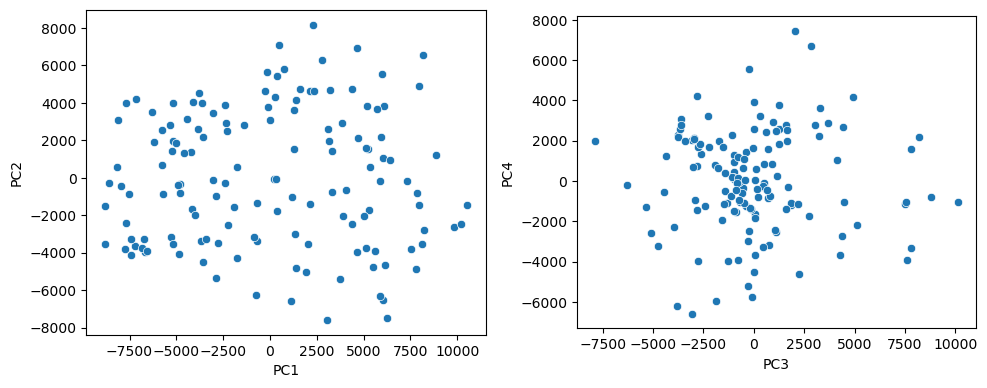

In [13]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 4 # PC number = 4, for limiting to 4 axes for morphospace reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

# add PCs to dataframe for plotting
PC_df = pd.DataFrame({
    "PC1":PCs[:,0],
    "PC2":PCs[:,1],
    "PC3":PCs[:,2],
    "PC4":PCs[:,3],
})

# visualize leaf distribution

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
sns.scatterplot(data=PC_df, x="PC1", y="PC2")
plt.gca().set_aspect("equal")

plt.subplot(1,2,2)
sns.scatterplot(data=PC_df, x="PC3", y="PC4")
plt.gca().set_aspect("equal")

plt.tight_layout()

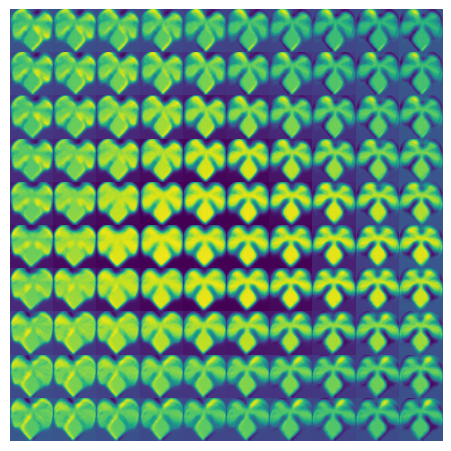

In [14]:
###############################
### EIGENLEAVES PCs 1 AND 2 ###
###############################

numPC1 = 10 # set number of PC1 intervals
numPC2 = 10 # set number of PC2 intervals

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

gs = gridspec.GridSpec(numPC1, numPC2, width_ratios=[1, 1, 1,1,1,1,1,1,1,1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

counter = 0 # create a counter for images

for i in range(len(PC2_vals)-1,-1,-1): # for each PC2 interval, reverse order
    for j in range(len(PC1_vals)): # for each PC1 interval
        
        pc1_val = PC1_vals[j] # select the current PC1 val
        pc2_val = PC2_vals[i] # select the current PC2 val
        pc3_val = 0
        pc4_val = 0

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val,pc3_val,pc4_val]))

        # reshape the array for imshow
        reshape_inv_lf = np.reshape(inv_leaf, (resolution, resolution))
        
        # plot
        plt.subplot(gs[counter])
        plt.imshow(reshape_inv_lf)
        plt.axis("off")
        
        counter += 1 #advance counter


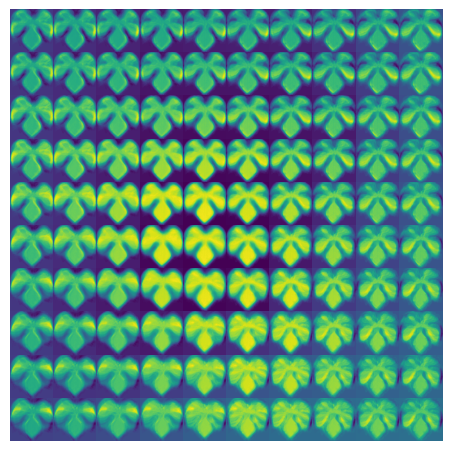

In [15]:
###############################
### EIGENLEAVES PCs 3 AND 4 ###
###############################

numPC3 = 10 # set number of PC3 intervals
numPC4 = 10 # set number of PC4 intervals

PC3_vals = np.linspace( np.min(PCs[:,2]), np.max(PCs[:,2]), numPC3 ) # create PC intervals
PC4_vals = np.linspace( np.min(PCs[:,3]), np.max(PCs[:,3]), numPC4 )

gs = gridspec.GridSpec(numPC3, numPC4, width_ratios=[1, 1, 1,1,1,1,1,1,1,1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

counter = 0 # create a counter for images

for i in range(len(PC4_vals)-1,-1,-1): # for each PC2 interval, reverse order
    for j in range(len(PC3_vals)): # for each PC1 interval
        
        pc3_val = PC3_vals[j] # select the current PC3 val
        pc4_val = PC4_vals[i] # select the current PC4 val
        pc1_val = 0
        pc2_val = 0

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val,pc3_val,pc4_val]))

        # reshape the array for imshow
        reshape_inv_lf = np.reshape(inv_leaf, (resolution, resolution))
        
        # plot
        plt.subplot(gs[counter])
        plt.imshow(reshape_inv_lf)
        plt.axis("off")
        
        counter += 1 #advance counter